In [362]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from pandas.tseries.offsets import DateOffset
from pandas.plotting import lag_plot, autocorrelation_plot
import numpy as np
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.api import acf, pacf, graphics
from statsmodels.graphics.tsaplots import plot_acf
from math import sqrt
from sklearn.metrics import mean_absolute_error

# Defaults for plotting
sns.set_style('darkgrid')
pd.plotting.register_matplotlib_converters()

# Default figure size
sns.mpl.rc('figure',figsize=(16, 6))
sns.mpl.rc('xtick', labelsize=13)    # fontsize x tick labels
sns.mpl.rc('ytick', labelsize=13)    # fontsize y tick labels
sns.mpl.rc('legend', fontsize=14)    # fontsize legend

## Load data

In [329]:
# Define paths
snp_data_path = '../data/snp_prices_daily_Jan_2019_May_2020.csv'
btc_data_path = '../data/bitcoin_may_2016_april_2020.csv'
snp_trends_data_path = '../data/snp_trends.csv'
btc_trends_data_path = '../data/bitcoin_trends.csv'

# Keep only the 'Data' and 'Close' (closing pirce) columns for both dataset
snp = pd.read_csv(snp_data_path, usecols=['Date','Close']).set_index('Date')
snp_trends = pd.read_csv(snp_trends_data_path, sep='\t').rename(columns={'date': 'Date', 's&p 500': 'Trends'}).set_index('Date')
snp.index = pd.to_datetime(snp.index)
snp.rename(columns={'Close': 'Price'}, inplace=True)
snp_trends = pd.merge(snp, snp_trends, left_index=True, right_index=True)

btc = pd.read_csv(btc_data_path, usecols=['Date','Close']).set_index('Date')
btc.index = pd.to_datetime(btc.index)
btc.rename(columns={'Close': 'Price'}, inplace=True)
btc = btc.asfreq(DateOffset(days=1))

# S&P 500
<hr>

In [189]:
# Replace the NaN values in the weekends with the the values close values in friday
# for i in range(len(snp)):
#     if snp.iloc[i].isnull().any():
#         snp.iloc[i] = snp.iloc[i-1]

In [330]:
snp_trends.head(10) # Weekends are missing

,Price,Trends
Date,,
2019-01-02,2510.030029,1602
2019-01-03,2447.889893,1800
2019-01-04,2531.939941,1494
2019-01-07,2549.689941,1314
2019-01-08,2574.409912,1476
2019-01-09,2584.959961,1314
2019-01-10,2596.639893,1476
2019-01-11,2596.260010,1134
2019-01-14,2582.610107,1044


### Plots

Text(0.5, 1.0, 'S&P 500 Trends price')

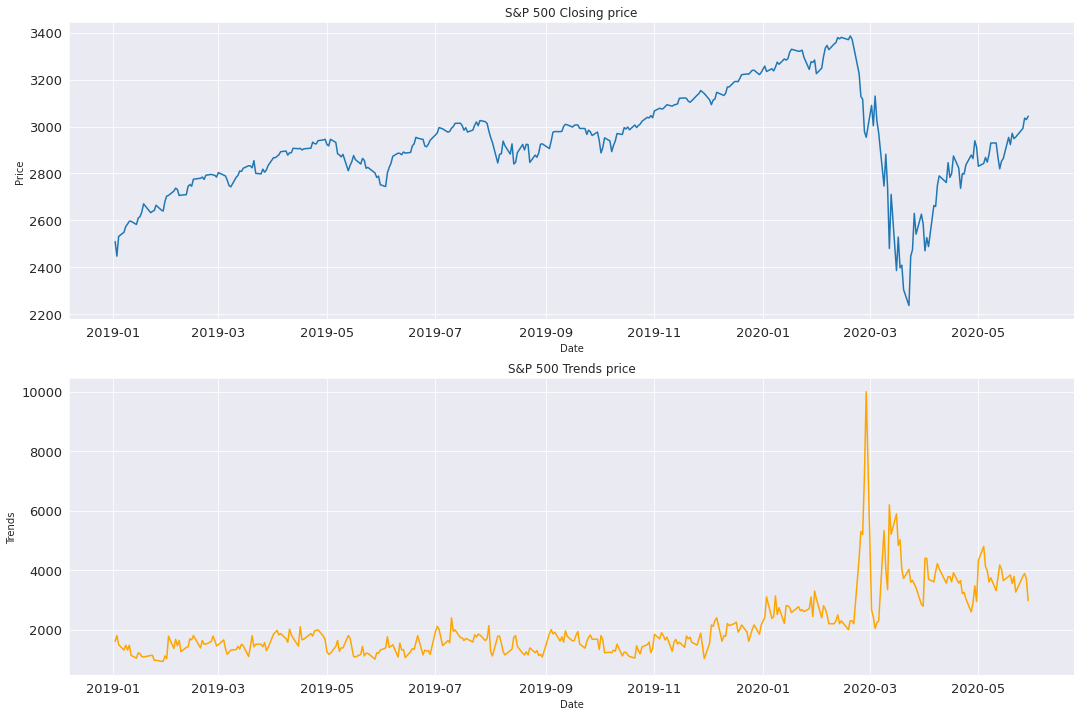

In [373]:
f, ax = plt.subplots(2, 1, figsize=(18,12))
sns.lineplot(data=snp_trends, x=snp_trends.index, y=snp_trends.Price, ax=ax[0]).set_title('S&P 500 Closing price')
sns.lineplot(data=snp_trends, x=snp_trends.index, y=snp_trends.Trends, color='orange', ax=ax[1]).set_title('S&P 500 Trends price')    

### Lag plot with lag(-1), lag(-2), lag(-5), lag(-12)

We can see that for some plots the data gather around a diagonal line.
We can say that there is some form of correlation between our series and the lagged ones.

This holds especially for `lag(-1)`, `lag(-2)`, `lag(-12)`. `Lag(-5)` seems to be the less correlated of them all.

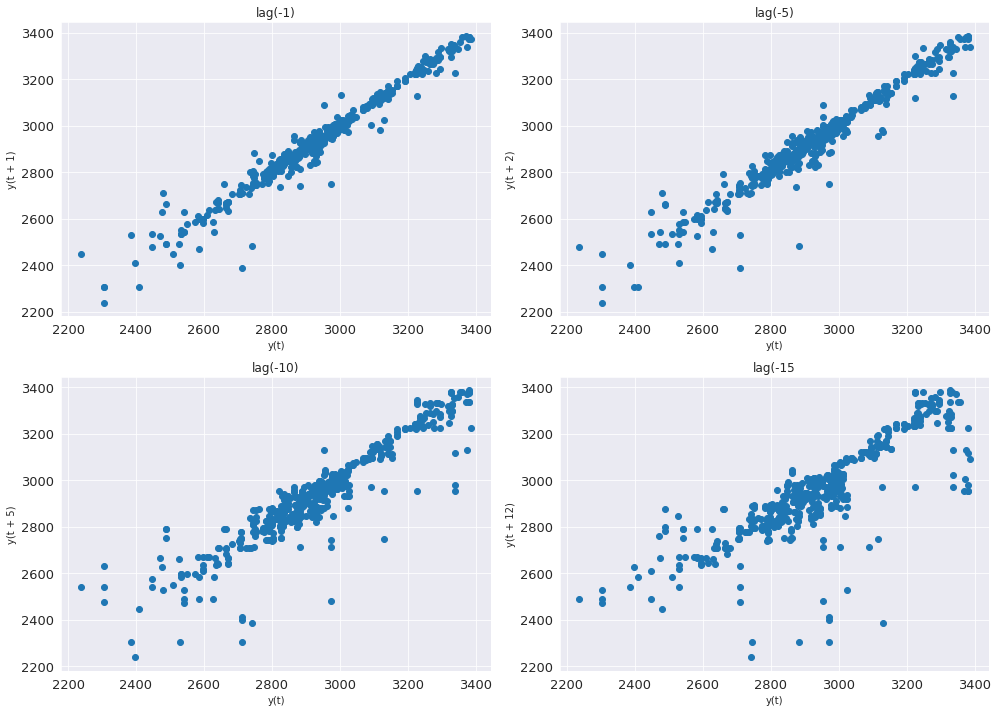

In [192]:
# Create the figure
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,10))

# Create all the lag plots: -1. -2, -5 , -12
lag_plot(snp[['Price']], 1,  ax=ax[0][0])
ax[0][0].set_title('lag(-1)')

lag_plot(snp[['Price']], 2,  ax=ax[0][1])
ax[0][1].set_title('lag(-5)')

lag_plot(snp[['Price']], 5,  ax=ax[1][0])
ax[1][0].set_title('lag(-10)')

lag_plot(snp[['Price']], 12, ax=ax[1][1])
ax[1][1].set_title('lag(-15')

fig.tight_layout()
plt.show()

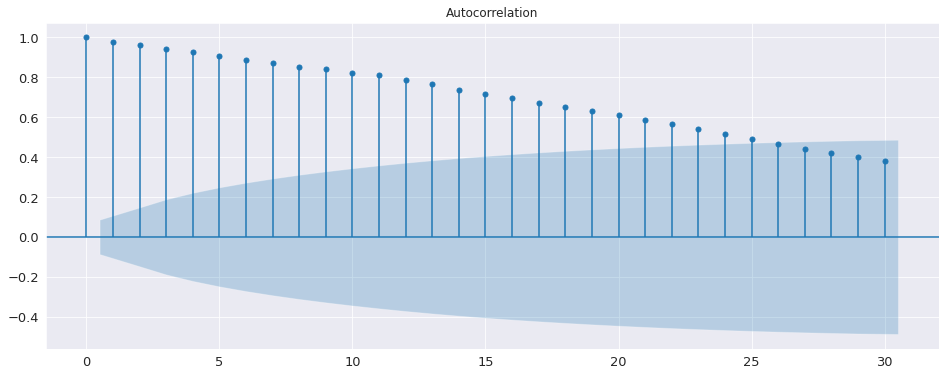

In [193]:
# plot the autocorrelation for 30 days
plot_acf(snp, lags=30)
plt.show()

## Build models

Use the `AutoReg` model from `statsmodels` to build and fit auto regression models to our data
<hr>

## In-sample models
Predict data that are already seen. Feed the whole data to the models and predict the whole time series

### Base in-sample model

In [302]:
base_snp = AutoReg(snp_trends.Price.values, lags=[1, 2, 3, 4, 5]).fit()
print(base_snp.summary())


                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  335
Model:                     AutoReg(5)   Log Likelihood               -1716.325
Method:               Conditional MLE   S.D. of innovations             43.906
Date:                Thu, 17 Dec 2020   AIC                              7.607
Time:                        22:58:36   BIC                              7.687
Sample:                             5   HQIC                             7.639
                                  335                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     81.0166     34.475      2.350      0.019      13.447     148.587
y.L1           0.6849      0.055     12.490      0.000       0.577       0.792
y.L2           0.5331      0.065      8.179      0.0

In [304]:
trends_snp = AutoReg(snp_trends.Price.values, lags=[1, 2, 3, 4, 5], exog=snp_trends.Trends.values).fit()
print(trends_snp.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  335
Model:                   AutoReg-X(5)   Log Likelihood               -1706.550
Method:               Conditional MLE   S.D. of innovations             42.624
Date:                Thu, 17 Dec 2020   AIC                              7.553
Time:                        22:58:41   BIC                              7.645
Sample:                             5   HQIC                             7.590
                                  335                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     99.5172     33.722      2.951      0.003      33.424     165.611
y.L1           0.6379      0.054     11.757      0.000       0.532       0.744
y.L2           0.5195      0.063      8.200      0.0

Base in sample MAE: 12.540
Trends in sample MAE: 14.752


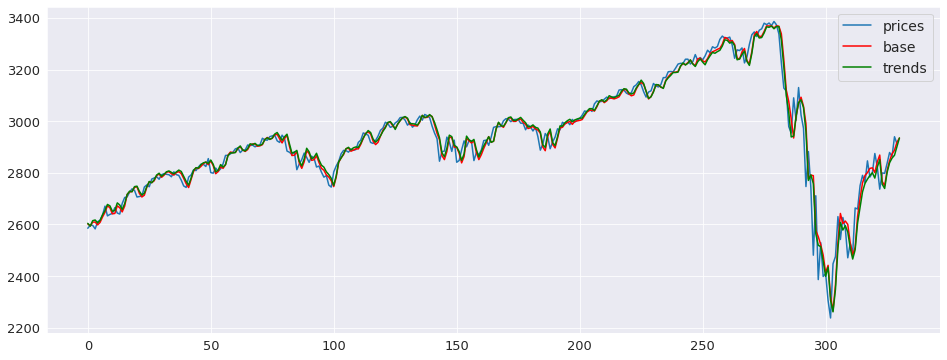

In [305]:
# In sample prediction for both models
pred_base = base_snp.predict(start=5, end=len(snp_trends.Price.values))
pred_trends = trends_snp.predict(start=5, end=len(snp_trends.Price.values), exog_oos=snp_trends.Trends.values)

# Compute MAE
mae_base = mean_absolute_error(snp_trends.iloc[4:,0], pred_base)
mae_trends = mean_absolute_error(snp_trends.iloc[4:,0], pred_trends)
print('Base in sample MAE: %.3f' % mae_base)
print('Trends in sample MAE: %.3f' % mae_trends)

# Plor in sample predictions (this is not the figure to reproduce!)
plt.plot(snp_trends.iloc[5:, 0].values )
plt.plot(pred_base, 'red')
plt.plot(pred_trends, 'green')
plt.legend(['prices', 'base', 'trends'])

## Out of sample models



In [336]:
# Out of sample base approach
y_base = []
y_trends = [] 

window_size = 12
for last_window_idx in range(snp_trends.shape[0] - window_size):  # Leaves out the last idx that we dont want eitherway
    roll = last_window_idx + window_size

    # Slice the original data to the training window
    price_window = snp_trends[:roll]['Price']

    # Slice the trends to the training window
    trends_window = snp_trends[:roll]['Trends']    

    # Train 2 modesl on the window
    base_model = AutoReg(price_window.values, lags= [1, 2, 3, 4, 5]).fit()
    trends_model = AutoReg(price_window.values, lags= [1, 2, 3, 4, 5], exog=trends_window.values).fit(use_t=True)
    
    # Predict using the params of the model (manually)
    y_base.append( 
        price_window.iloc[-1] * base_model.params[1] + 
        price_window.iloc[-2] * base_model.params[2] + 
        price_window.iloc[-3] * base_model.params[3] + 
        price_window.iloc[-4] * base_model.params[4] + 
        price_window.iloc[-5] * base_model.params[5] + 
        base_model.params[0])

    y_trends.append(          
        price_window.iloc[-1] * trends_model.params[1] + 
        price_window.iloc[-2] * trends_model.params[2] + 
        price_window.iloc[-3] * trends_model.params[3] + 
        price_window.iloc[-4] * trends_model.params[4] + 
        price_window.iloc[-5] * trends_model.params[5] + 
        snp_trends.iloc[roll]['Trends'] * trends_model.params[6] +
        trends_model.params[0])

In [340]:
prices_to_pred = snp_trends.iloc[window_size:, 0]

print(f'Mae base: {mean_absolute_error(prices_to_pred.values, y_base)}')
print(f'Mae trends: {mean_absolute_error(prices_to_pred.values, y_trends)}')

Mae base: 28.83225642985474
Mae trends: 29.341725712617244


# Bitcoin


In [74]:
btc.head() # Weekends are missing

,Price
Date,
2019-01-02,2510.030029
2019-01-03,2447.889893
2019-01-04,2531.939941
2019-01-07,2549.689941
2019-01-08,2574.409912


Text(0.5, 1.0, 'Bitcoin Closing price')

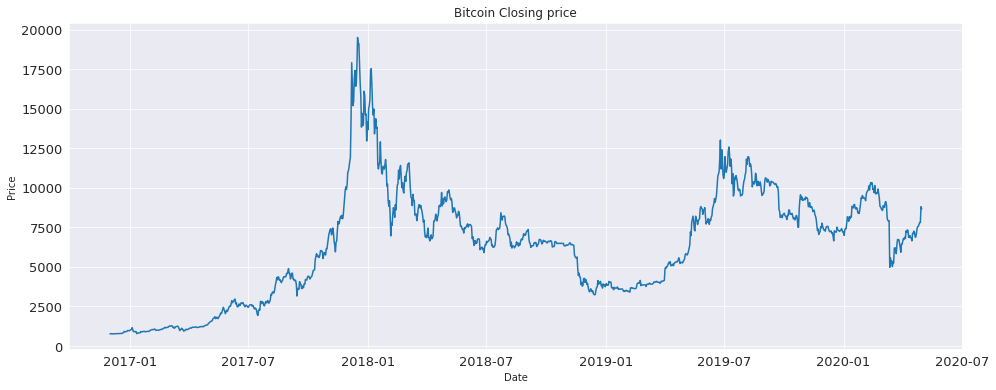

In [78]:
sns.lineplot(data=btc, x=btc.index, y=btc.Price).set_title('Bitcoin Closing price')

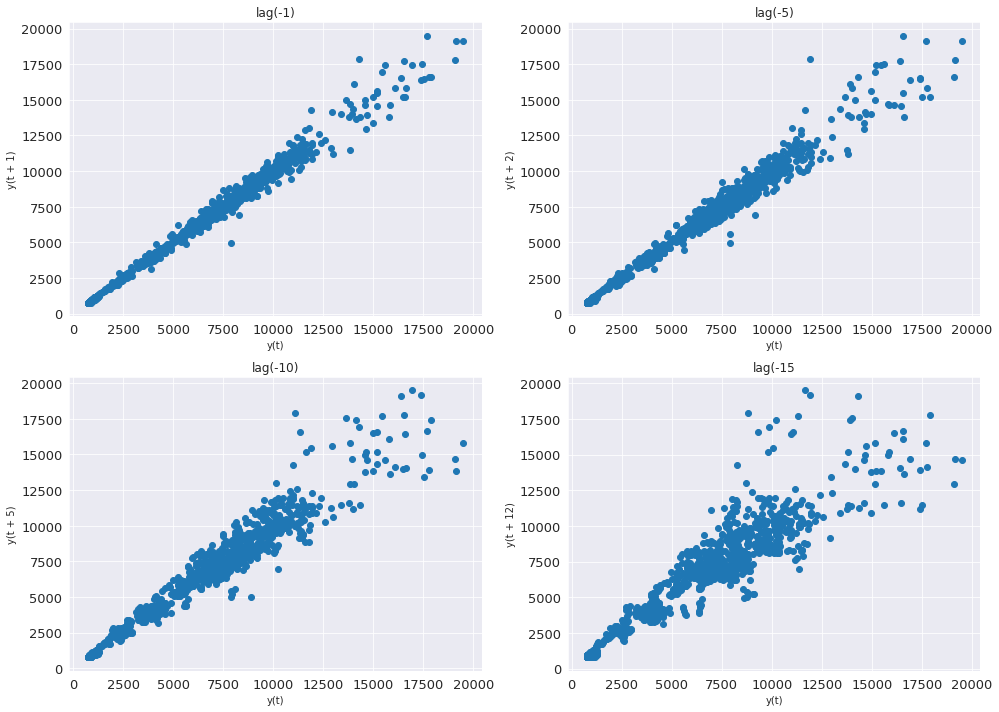

In [79]:
# Create the figure
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,10))

# Create all the lag plots: -1. -2, -5 , -12
lag_plot(btc[['Price']], 1,  ax=ax[0][0])
ax[0][0].set_title('lag(-1)')

lag_plot(btc[['Price']], 2,  ax=ax[0][1])
ax[0][1].set_title('lag(-5)')

lag_plot(btc[['Price']], 5,  ax=ax[1][0])
ax[1][0].set_title('lag(-10)')

lag_plot(btc[['Price']], 12, ax=ax[1][1])
ax[1][1].set_title('lag(-15')

fig.tight_layout()
plt.show()

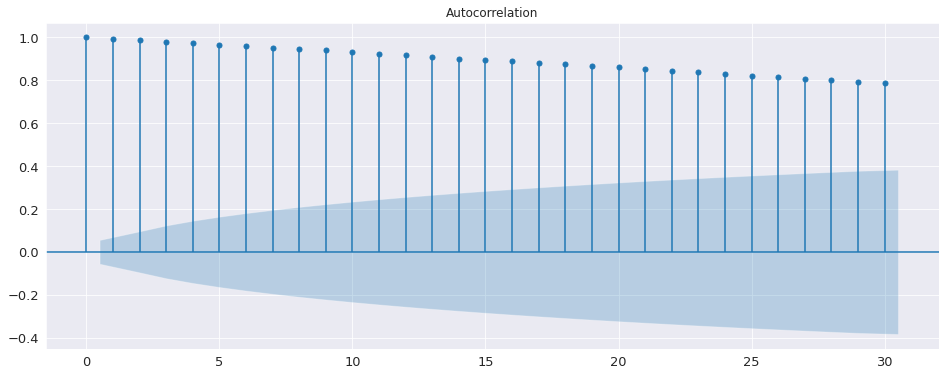

In [80]:
# plot the autocorrelation for 30 days
plot_acf(btc, lags=30)
plt.show()